In [2]:
from pathlib import Path

from pyaqua3ddev.image.image_processors.raw_processor import RawProcessor
from pyfishsensedev.image.pdf import Pdf
from pyfishsensedev.plane_detector.slate_detector import SlateDetector
import numpy as np
import matplotlib.pyplot as plt
from skimage.util import img_as_ubyte
from pyfishsensedev.calibration.lens_calibration import LensCalibration
import torch
from pyfishsensedev.library.homography import viz2d
from pyfishsensedev.library.homography.utils import numpy_image_to_torch
from pyfishsensedev.library.homography.image_matcher import ImageMatcher
import cv2

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

device

'cuda'

In [4]:
input_file = Path("./data/P8310016.ORF")
pdf_file = Path("./data/Dive Slate#1.pdf")
lens_calibration_file = Path("./data/fsl-05d-lens-raw.pkg")

input_file.exists(), pdf_file.exists(), lens_calibration_file.exists()

(True, True, True)

In [76]:
def imshow(image: np.ndarray, color="bgr"):
    image = img_as_ubyte(image)

    if image.ndim == 3:
        if color == "bgr":
            image = image[:, :, ::-1]

    plt.imshow(image)

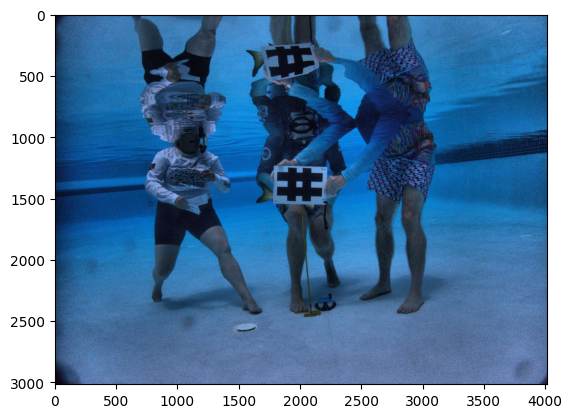

In [6]:
raw_processor = RawProcessor()
img = raw_processor.process(input_file)

imshow(img)

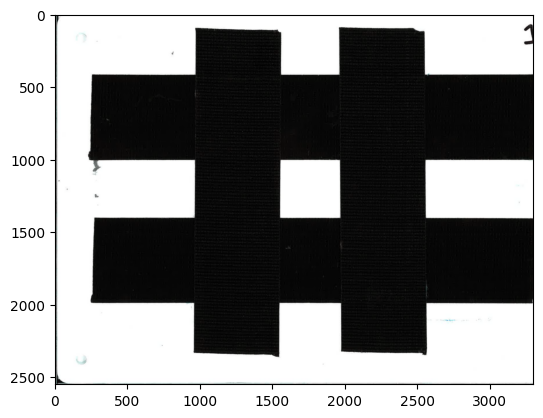

In [7]:
pdf = Pdf(pdf_file, rotation_degree=180)

imshow(pdf.image)

In [8]:
lens_calibration = LensCalibration()
lens_calibration.load(lens_calibration_file)

lens_calibration.camera_matrix

array([[2.83327797e+03, 0.00000000e+00, 2.00975722e+03],
       [0.00000000e+00, 2.85877370e+03, 1.40798662e+03],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

/home/chris/Repos/school/e4e/fishsense/pyFishSenseDev/pyfishsensedev/library/homography/models/lightglue.py:29: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


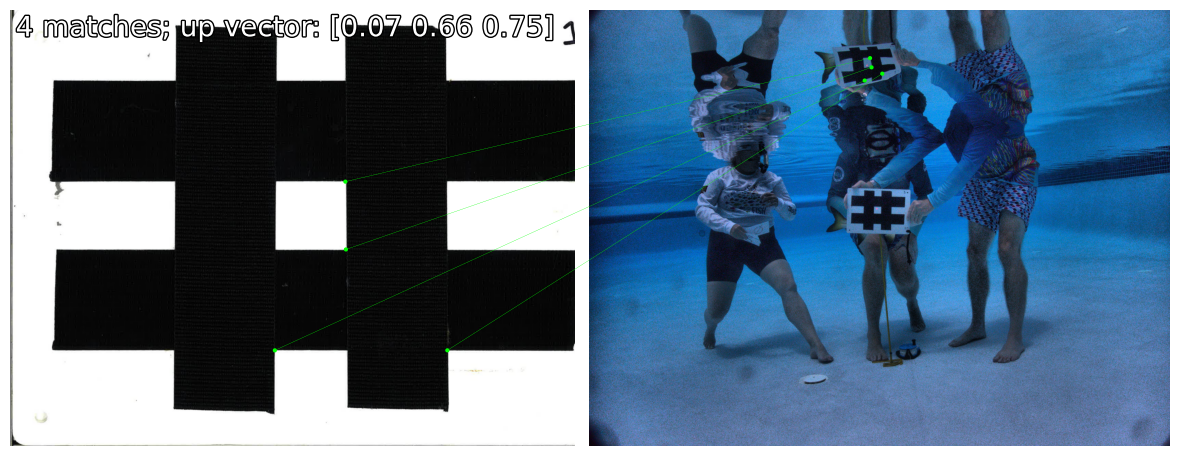

In [9]:
slate_detector = SlateDetector(img_as_ubyte(img), pdf, lens_calibration, device)
template_matches, image_matches = slate_detector._get_template_matches()

rotation, _ = slate_detector._get_body_to_camera_space_transform()

viz2d.plot_images([pdf.image, img[:, :, ::-1]])
viz2d.plot_matches(template_matches, image_matches, color="lime", lw=0.2)
viz2d.add_text(
    0,
    f"{len(template_matches)} matches; up vector: {np.round(rotation @ np.array([0, 1, 0]) * 100.0) / 100.0}",
    fs=20,
)
plt.show()

In [ ]:
def get_mask(image: np.ndarray, pdf: Pdf, rotation: np.ndarray, translation: np.ndarray, camera_matrix: np.ndarray):
    img_height, img_width, _ = image.shape

    constant = 0.2

    # List of 3D points on the plane (Nx3 array)
    plane_points_3D = np.array([
        [0, 0, 0],  # Point 1
        [1.5*constant, 0, 0],  # Point 2
        [1.5*constant, constant, 0],   # Point 3
        [0, constant, 0],  # Point 4 (for a quadrilateral plane)
    ], dtype=np.float64)

    # Project 3D points onto 2D image plane
    plane_points_cam = (rotation @ plane_points_3D.T + translation).T  # Transform to camera frame
    plane_points_2D = (camera_matrix @ plane_points_cam.T).T  # Apply camera intrinsics

    # Normalize to get pixel coordinates
    plane_points_2D = (plane_points_2D[:, :2] / plane_points_2D[:, 2:]).astype(np.int32)

    mask = np.zeros((img_height, img_width), dtype=np.uint8)
    cv2.fillPoly(mask, [plane_points_2D], 255)

    return mask

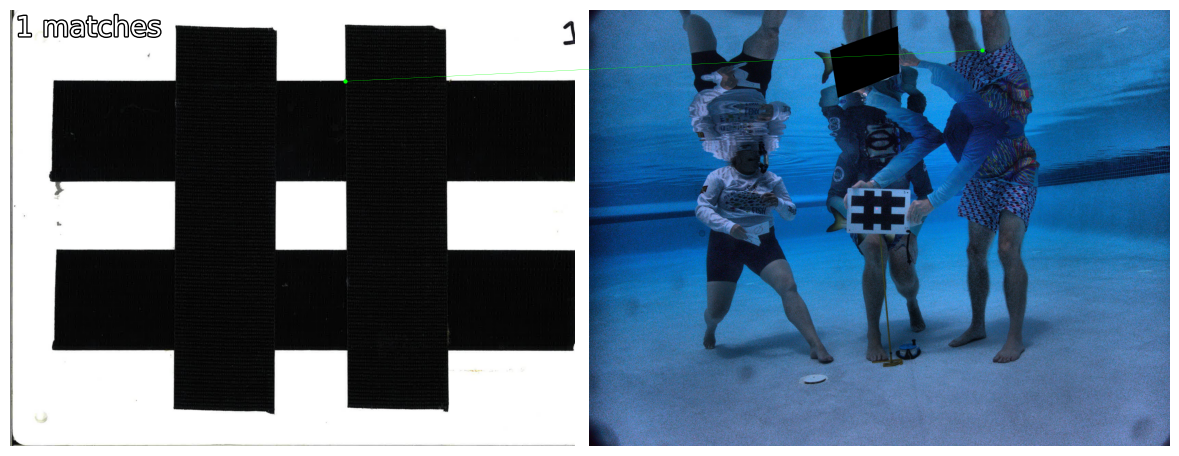

In [192]:
# image = img.copy()
tensor_template = numpy_image_to_torch(pdf.image)
max_num_keypoints = 0
template_matches = None
image_matches = None

while True:
    prev_num_keypoints = max_num_keypoints

    if template_matches is not None and image_matches is not None:
        rotation, translation = slate_detector._get_body_to_camera_space_transform()

        mask = get_mask(image, pdf, rotation, translation, lens_calibration.camera_matrix)
        image[mask == 255, :] = 0

    for scale in range(1, 20):
        scale = float(scale) / 10.0

        image_matcher = ImageMatcher(
            tensor_template,
            device,
            com_license=False,
            processing_conf={
                "preprocess": {
                    "gamma": 1.6,
                    "sharpness": None,
                    "scale": scale,
                },
                "matcher": {"filter_threshold": 0.5},
            },
        )

        template_matches, image_matches = image_matcher(
            numpy_image_to_torch(image)
        )

        num_keypoints, _ = template_matches.shape
        if num_keypoints > max_num_keypoints:
            max_num_keypoints = num_keypoints

            max_template_matches = template_matches
            max_image_matches = image_matches

    if prev_num_keypoints == max_num_keypoints:
        break

# masked_image = image.copy()
# masked_image[mask == 255, :] = 0
# imshow(masked_image)
viz2d.plot_images([pdf.image, image[:, :, ::-1]])
viz2d.plot_matches(max_template_matches, max_image_matches, color="lime", lw=0.2)
viz2d.add_text(
    0,
    f"{len(max_template_matches)} matches",
    fs=20,
)
plt.show()